In [8]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
import seaborn as sns

# Spark session & context
spark = (
    SparkSession.builder
    .master("local[*]")
    .config("spark.sql.catalogImplementation", "hive")
    .enableHiveSupport()
    .getOrCreate()
)
sc = spark.sparkContext

spark.sql("CREATE DATABASE IF NOT EXISTS obsidian_metrics_db")
spark.sql("USE obsidian_metrics_db")
spark.sql("""
    CREATE TABLE files_metrics (
        date DATE,
        name STRING,
        word_count INT,
        type STRING,
        about STRING,
        sentiment INT,
        tags ARRAY<string>,
        links ARRAY<string>
    )
""")


AnalysisException: Hive support is required to CREATE Hive TABLE (AS SELECT);
'CreateTable `obsidian_metrics_db`.`files_metrics`, org.apache.hadoop.hive.serde2.lazy.LazySimpleSerDe, ErrorIfExists


In [10]:
spark.sparkContext.getConf().get("spark.sql.catalogImplementation")

In [24]:
AVG_WORDS_PER_MINUTE_ADULTS = 238 # https://www.sciencedirect.com/science/article/abs/pii/S0749596X19300786


df = (
    spark.read.text("data/pages", wholetext=True)
    .withColumn(
        "filename", 
        f.regexp_replace(
            f.reverse(
                f.split(
                    f.input_file_name(), 
                    '/')
                )[0],
            "%20", " "))
    .withColumn("words", f.size(f.split(f.col('value'), ' ')))
    .withColumn("reading_minutes", f.round(f.col("words")/AVG_WORDS_PER_MINUTE_ADULTS, 2))
    .orderBy('words', ascending=False)
    .select(["filename", "words", "reading_minutes"])
    .toPandas()
)
df

TypeError: DataFrameReader.text() got an unexpected keyword argument 'recursive'

In [ ]:
df = (
    spark.read.text("data/pages")
    .withColumn(
        "filename", 
        f.regexp_replace(
            f.reverse(
                f.split(
                    f.input_file_name(), 
                    '/')
                )[0],
            "%20", " "))
    # Filter by lines that have "Tags::"
    .filter(f.col("value").rlike("Tags::"))
    # Split by "::" and get the second element
    .withColumn("tags", f.split(f.col("value"), "::")[1])
    # Split by two expressions: ", [" and ", #"
    .withColumn("tags", f.split(f.col("tags"), ", \[|, \#"))
    # Explode the list of tags
    .withColumn("tags", f.explode(f.col("tags")))
    # Remove the spaces
    .withColumn("tags", f.trim(f.col("tags")))
    # Remove the empty strings
    .filter(f.col("tags") != "")
    # Group by tags and count
    .groupBy("tags")
    .count()
    .orderBy("count", ascending=False)
)

<Axes: xlabel='reading_minutes', ylabel='Percent'>

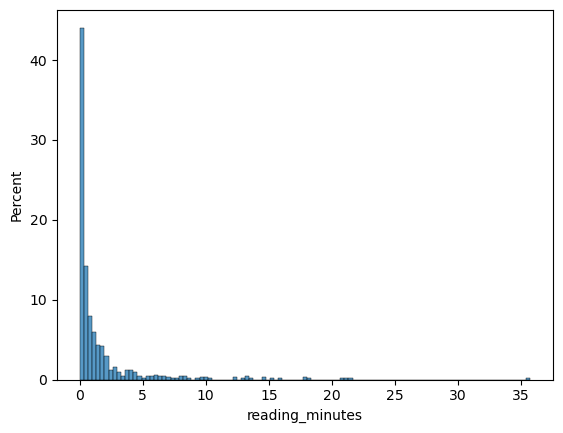

In [51]:
sns.histplot(data=df, x="reading_minutes", stat='percent')

<Axes: xlabel='reading_minutes', ylabel='Count'>

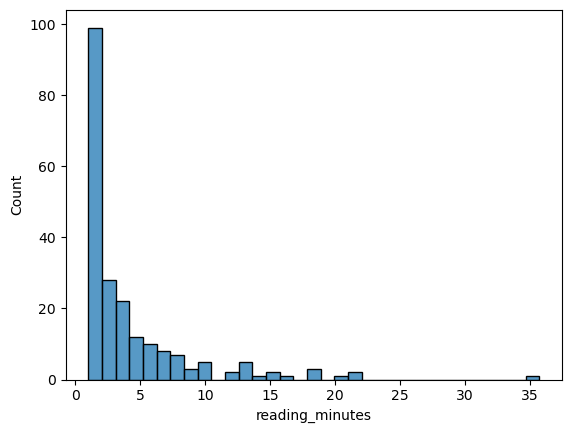

In [52]:
sns.histplot(data=df, x="reading_minutes", stat='percent')


""
